This notebook should predict WB_sg from 9 input features.

Andrew Fagerheim and Bernard Wang

In [86]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
cwd = os.getcwd()
input_features = ['grad_B','FCOR', 'HML', 'Nsquared', 'Q', 'TAU', 'HBL', 'strain', 'vort', 'div']
# 0. Depth-averaged buoyancy gradient magnitude
# 1. Coriolis parameter
# 2. Mixed layer depth
# 3. Brunt-Vaisala frequency
# 4. Surface heat flux
# 5. Surface wind stress magnitude
# 6. Boundary layer depth
# 7. Depth-averaged strain magnitude
# 8. Depth-averaged vertical vorticity
# 9. Depth-averaged horizontal divergence
output_feature = 'WB_sg'
# 10. Depth-averaged vertical bouyancy flux

# Things about the data and model we are learning:
- There are 10 input features, 1 output feature.
- 12 locations, each with 846 time ticks. 14 months, September 2011 to November 2012 it seems. Indices 0-845 is one location. Then 846-846+845 is another location.
- Seems like there are two roughly two time ticks per day. 2/day __makes sense?__
- They are 40 by 40 boxes. they have lat/lon of 15x15 boxes by the way. Paper says it has been coarsened to 1/4 degree grid.  __makes sense?__
- would it be helpful to have the actual latitude and longitudes? or does it not matter? i'm cool with not having em..
  - but, we want to weigh our data, no?? without lat, we don't weight our data properly......
  - features are allegedly normalized by their regional mean and standard deviation. again, do we want to weigh our data with latitude?
- Model selects 80% of the 10,152 samples from all regions combined to TRAIN. Selects the remaining 20% to test, and compare with the target LLC4320 data.
- the CNN/NN example notebooks use CO2 and CH4, which only have one value per time tick, rather than one for each lat/lon pair. So, they are 1-D time series rather than 3-D time series. Here, we have 3-D time series used to train. Have to figure out how to shove that data into the model.
- Also have to figure out how to concatenate all the different locations' data and put into the model. How do they get added in? __figure this out__

# We are gonna just use all 10152 time indices. All 846 time indices for 12 locations.

#### Load Input

In [88]:
# load input. (We gonna look at all 10152 time indices)

# 1. Create xarray dataset, populate it with the numpy files but turn them into dataarrays.
X_xr = xr.Dataset()
for input_feature in input_features:
    var = np.load('data/%s.npy' % input_feature)
    var_xr = xr.DataArray(var, coords={'time': np.arange(0, len(var)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
    X_xr[input_feature] = var_xr
# X_xr is created, which is a Dataset that has all of the input variables time series. It has a lat/lon component though, I hope that is ok?

In [89]:
X_xr

<xarray.Dataset>
Dimensions:   (time: 10152, lat: 40, lon: 40)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 10146 10147 10148 10149 10150 10151
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
Data variables:
    grad_B    (time, lat, lon) float64 6.694e-09 8.443e-09 ... 3.043e-08
    FCOR      (time, lat, lon) float64 2.957e-07 2.957e-07 ... -4.146e-05
    HML       (time, lat, lon) float32 -66.88 -65.39 -66.05 ... -49.81 -59.09
    Nsquared  (time, lat, lon) float64 3.006e-06 3.223e-06 ... 1.607e-06
    Q         (time, lat, lon) float32 -76.76 -75.69 -76.19 ... -43.1 -52.33
    TAU       (time, lat, lon) float32 0.05946 0.05947 0.05856 ... 0.1419 0.1394
    HBL       (time, lat, lon) float32 43.4 43.05 43.19 ... 46.26 42.09 46.62
    strain    (time, lat, lon) float64 2.933e-06 1.681e-06 ... 4.448e-06
    vort      (time, lat, lon) float64 -1.361e-06 5.121e-07 ... 6.297e-06
    div       (time, lat, lon) float64 4.879e-07 6.407e-08 ... -5.795e-07

In [90]:
# Determine the random part of the dataset that will be training data, and the other part will be testing data.
train_split = 0.8

time_indices = len(X_xr.time)
train_cutoff = round(train_split*time_indices)
rand_indices = np.arange(time_indices)
np.random.shuffle(rand_indices)

# THESE INDICES WILL BE USED FOR BOTH THE INPUT AND OUTPUT.
train_indices = rand_indices[:train_cutoff]
test_indices = rand_indices[train_cutoff:]

In [28]:
# Train indices: random 80% of the data. Test indices: random 20% of the data.
X_train_xr = X_xr.isel(time=train_indices)
X_test_xr = X_xr.isel(time=test_indices)

# similar to CNN-LSTM example. get the mean, std of the entire training data.
meanstd_inputs = {}
#meanstd_inputs
for input_feature in input_features:
    meanstd_inputs[input_feature] = (X_train_xr[input_feature].data.mean(),X_train_xr[input_feature].data.std())

X_xr = xr.Dataset()
for input_feature in input_features:
    var = np.load('data/%s.npy' % input_feature)
    var_xr = xr.DataArray(var, coords={'time': np.arange(0, len(var)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
    X_xr[input_feature] = var_xr
    
    
var_dims = ('time', 'lat', 'lon') # Every single input variable has the three dimensions.
# normalize.
for input_feature in input_features:
    # training set
    X_train_xr = X_train_xr.assign({input_feature: (var_dims, normalize(X_train_xr[input_feature].data, input_feature, meanstd_inputs))})
    
    # test set
    X_test_xr = X_test_xr.assign({input_feature: (var_dims, normalize(X_test_xr[input_feature].data, input_feature, meanstd_inputs))})
    
# normalize() function is in the utils.py file by the way.
# every variable in the two normalized datasets should now have mean of 0 and std of 1.

In [ ]:
# # 2. Build the dataframe, by going through each input feature and adding its timeseries.
# train_vars = {}
# for input_feature in input_features:
#     train_vars[input_feature] = X_train_xr[input_feature].mean(dim=['lat','lon']) # CO2 AND CH4 IN CLASS ARE 1D...
#     # NOTE: we are taking the mean for now, because the input variables still have lat/lon properties. maybe we treat it like the output????
# X_train_df = pd.DataFrame(train_vars, index=X_train_xr["grad_B"].coords['time'].data)

# test_vars = {}
# for input_feature in input_features:
#     test_vars[input_feature] = X_test_xr[input_feature].mean(dim=['lat','lon']) # CO2 AND CH4 IN CLASS ARE 1D...
#     # NOTE: we are taking the mean for now, because the input variables still have lat/lon properties. maybe we treat it like the output????
# X_train_df = pd.DataFrame(train_vars, index=X_train_xr["grad_B"].coords['time'].data)
# X_test_df = pd.DataFrame(test_vars, index=X_test_xr["grad_B"].coords['time'].data)

# X_train_df.head()
# X_train_df.shape
# X_test_df.shape

#### Load Output

In [29]:
# 1. load WB_sg numpy file from data.
# Vertical Buoyancy Flux
WB_sg = np.load('data/WB_sg.npy')
# 2. turn the data into an xarray dataarray
WB_sg_xr = xr.DataArray(WB_sg, coords={'time': np.arange(0, len(WB_sg)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])

y_train_xr = WB_sg_xr.isel(time=train_indices)
y_train_np = y_train_xr.data
y_test_xr = WB_sg_xr.isel(time=test_indices)
y_test_np = y_test_xr.data

In [115]:
# # Data normalization
# mean, std = X_train_df.mean(), X_train_df.std()

# X_train_df_norm   = (X_train_df - mean)/std
# X_test_df_norm    = (X_test_df - mean)/std

# X_train = X_train_df_norm.to_numpy()
# X_test = X_test_df_norm.to_numpy()

# print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(8122, 10) (8122, 40, 40) (2030, 10) (2030, 40, 40)


In [30]:
X_train_np = X_train_xr.to_array().transpose('time', 'lat', 'lon', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'lat', 'lon', 'variable').data
lat, lon, num_inputs = X_train_np.shape[1:]

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(8122, 40, 40, 10) (8122, 40, 40) (2030, 40, 40, 10) (2030, 40, 40)


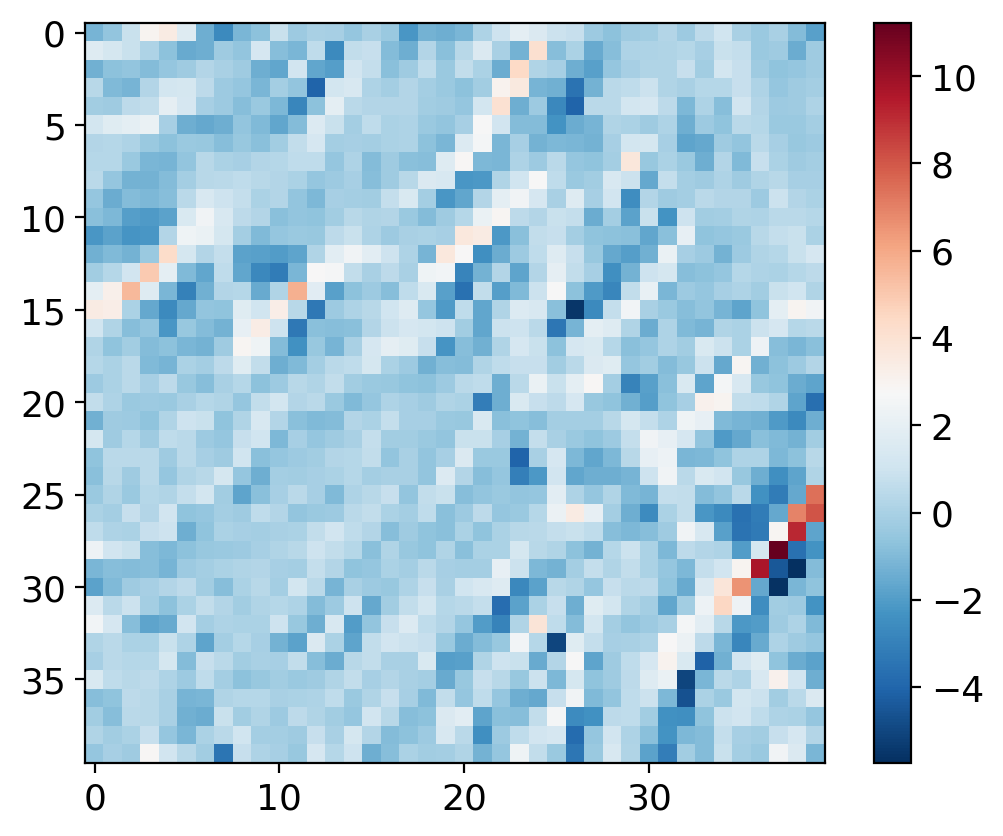

In [97]:
# Still ordered WB_sg_xr
# plt.imshow(np.flip(WB_sg_xr.data[1],axis=0),cmap='RdBu_r')
plt.imshow(np.flip(X_train_xr['div'].isel(time=2).data, axis=0), cmap='RdBu_r')

# Randomized order, 80% of WB_sg_xr. aka y_train
#plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

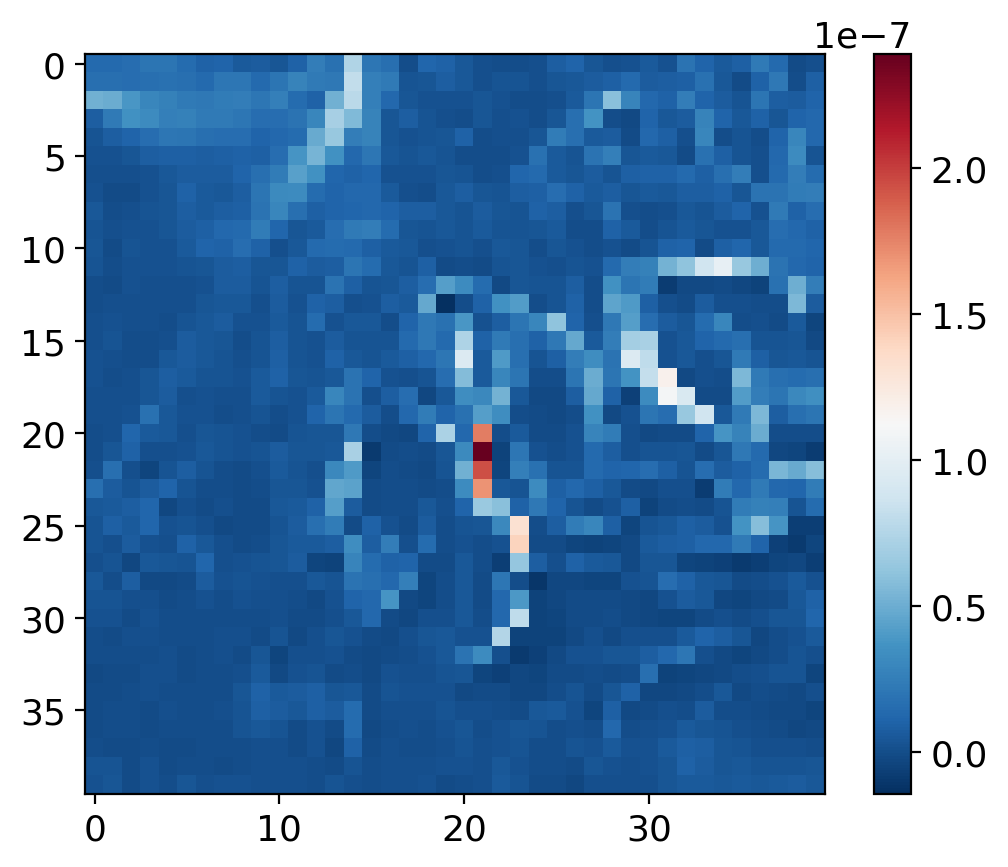

In [32]:
# looking at a still ordered, non-normalized WB_sg_xr
plt.imshow(np.flip(WB_sg_xr.data[1],axis=0),cmap='RdBu_r')

# Randomized order, 80% of WB_sg_xr. aka y_train
#plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

## Define CNN Structure

In [33]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 5
hidden_kernel_size = 3
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [34]:
X_train_np.shape
# (8122, 40, 40, 10)
# input wants to be (batch_size, height, width, channels) so I think this is fine.
# There should be 10 (or however many variables we want to use) input channels.
# There should be 1 output channel: the WB_sg variable.

(8122, 40, 40, 10)

In [102]:
### model using MSE as loss function
# FIGURING OUT TO SHOVE THE X_TRAIN_NP AND Y_TRAIN_NP INTO THIS MODEL.

model_mse = Sequential()

model_mse.add(Conv2D(filters=128, kernel_size = kernel_size, input_shape = X_train_np.shape[1:],
                    activation=activation, padding='same'))
model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
# model_mse.add(Flatten())
# model_mse.add(Dense(40*40, activation= 'linear'))
# model_mse.add(Reshape((1, 40, 40)))

# FULLY CONVOLUTIONAL NEURAL NETWORK. DENSE LAYER IS NOT IMPLEMENTED.
# we don't want to fix the size of the input, which is what the dense layer does. fully convolution: easily translates to other
    
# have a really shitty model versus a really good model. when looking at r^2
# make a model where the activation function isn't relu, but it's linear.
    
model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 40, 40, 128)       32128     
                                                                 
 conv2d_30 (Conv2D)          (None, 40, 40, 64)        73792     
                                                                 
 conv2d_31 (Conv2D)          (None, 40, 40, 32)        18464     
                                                                 
Total params: 124,384
Trainable params: 124,384
Non-trainable params: 0
_________________________________________________________________


In [99]:
### model using MSE as loss function
# FIGURING OUT TO SHOVE THE X_TRAIN_NP AND Y_TRAIN_NP INTO THIS MODEL.

model_mse = Sequential()

model_mse.add(Conv2D(filters=n_filters, kernel_size = kernel_size, input_shape = X_train_np.shape[1:],
                    activation=activation, padding='same'))
model_mse.add(MaxPooling2D((2, 2)))

model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))
model_mse.add(MaxPooling2D((2, 2)))
              
model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))
model_mse.add(MaxPooling2D((2, 2)))

model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))
model_mse.add(MaxPooling2D((2, 2)))

model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))

model_mse.add(Flatten())
model_mse.add(Dense(40*40, activation= activation))
model_mse.add(Reshape((1, 40, 40)))
    
model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 40, 32)        8032      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 64)        

## Train da model

In [39]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

###------------mse------------
history_mse = model_mse.fit(X_train_np, y_train_np, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
102/102 [==============================] - 13s 123ms/step - loss: 4.5796e-05 - val_loss: 2.4709e-10
Epoch 2/100
102/102 [==============================] - 13s 124ms/step - loss: 1.4799e-10 - val_loss: 1.0480e-10
Epoch 3/100
102/102 [==============================] - 12s 120ms/step - loss: 6.1689e-11 - val_loss: 6.6125e-11
Epoch 4/100
102/102 [==============================] - 12s 119ms/step - loss: 3.3764e-11 - val_loss: 4.3078e-11
Epoch 5/100
102/102 [==============================] - 12s 120ms/step - loss: 2.0227e-11 - val_loss: 3.1760e-11
Epoch 6/100
102/102 [==============================] - 12s 120ms/step - loss: 1.3465e-11 - val_loss: 2.4327e-11
Epoch 7/100
102/102 [==============================] - 12s 123ms/step - loss: 9.3971e-12 - val_loss: 1.9578e-11
Epoch 8/100
102/102 [==============================] - 12s 121ms/step - loss: 6.9982e-12 - val_loss: 1.6064e-11
Epoch 9/100
102/102 [==============================] - 12s 122ms/step - loss: 5.2647e-12 - val_loss: 1.3

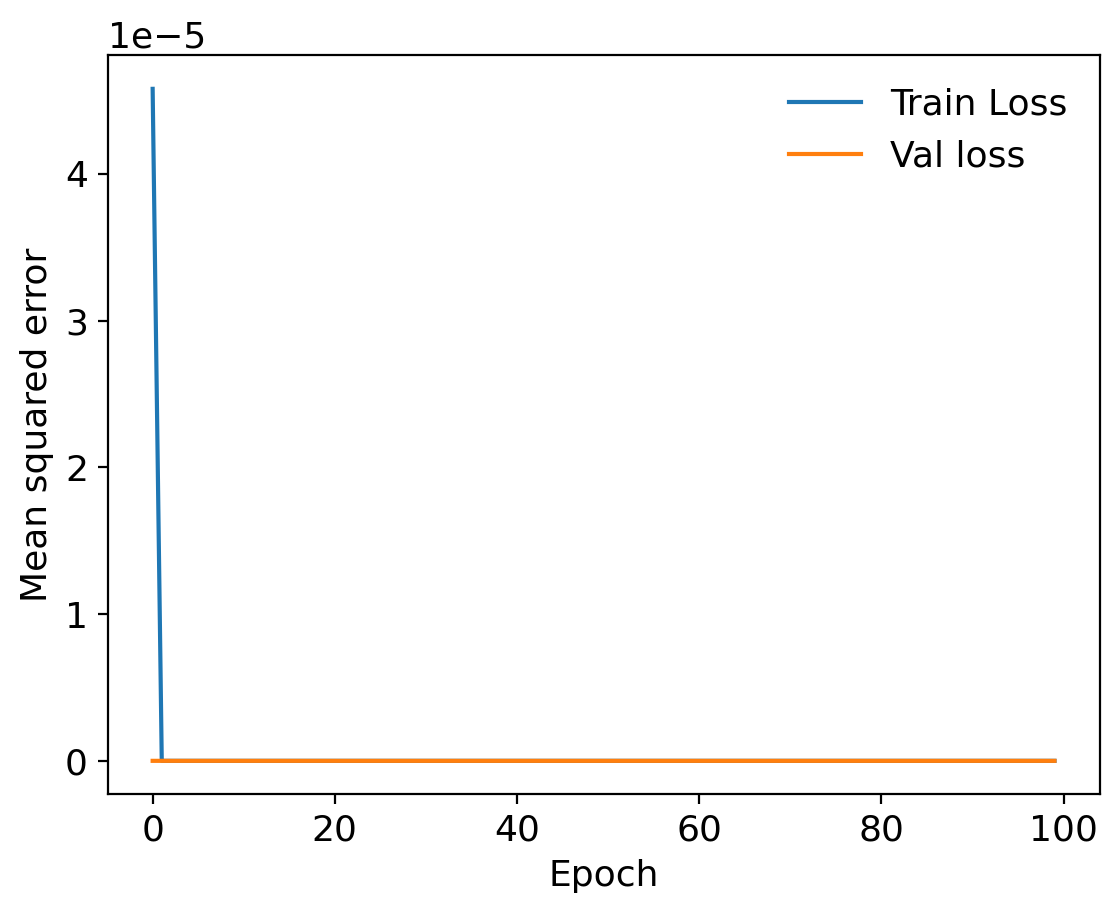

In [40]:
plot_history(history_mse)

In [41]:
model_path = os.path.join(cwd,'model')
make_dir(model_path)

In [42]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN_model_mse.h5'))
# we should save the testing data too right? Save y_test_xr here.
y_test_xr.to_netcdf(os.path.join(model_path,'y_test.nc'))


# Evaluate da Trained Model

In [43]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN_model_mse.h5'))

In [55]:
y_test_mse_pre = model_mse.predict(X_test_np)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 40, 40)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'lat': X_test_xr.lat.values, 
                               'lon': X_test_xr.lon.values},
                       data_vars=dict(WB_sg=(['time', 'lat', 'lon'], y_test_mse_pre)))

64/64 [==============================] - 1s 15ms/step


In [85]:
y_test_mse_pre.WB_sg

<xarray.DataArray 'WB_sg' (time: 2030, lat: 40, lon: 40)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) int64 7869 6655 1316 4339 2308 ... 3664 6355 8790 9424 1017
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39

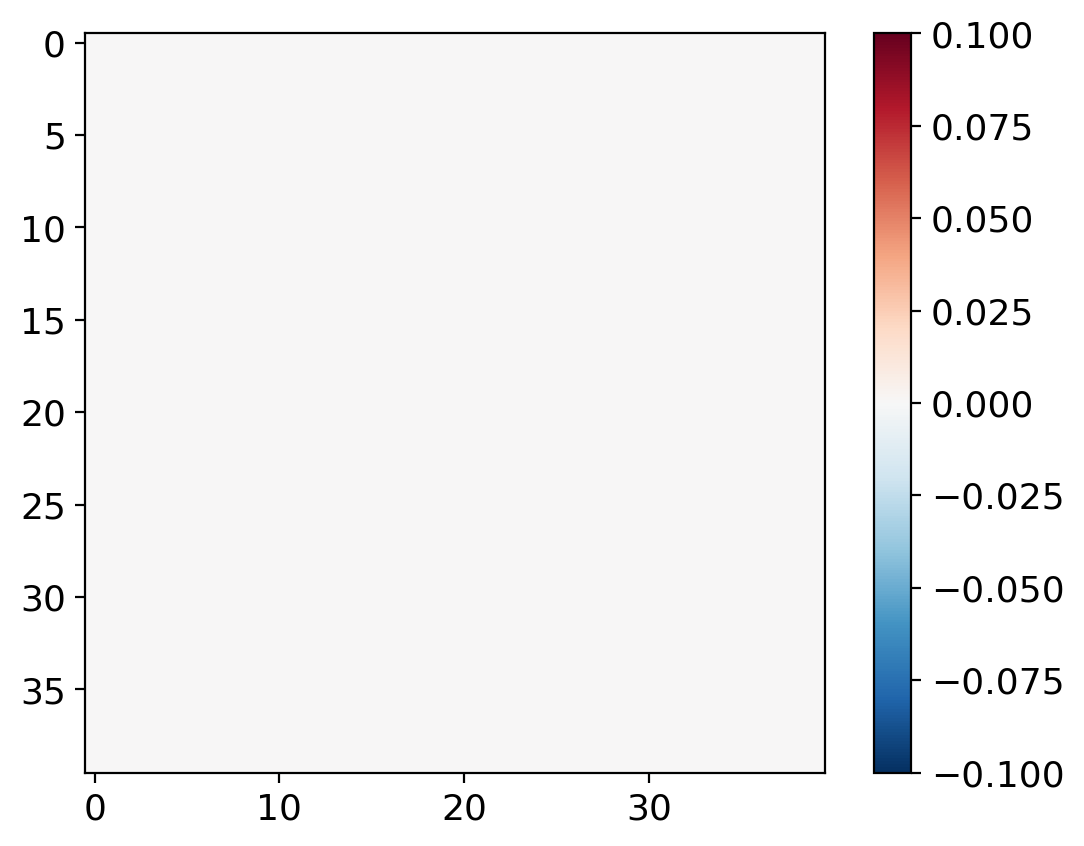

In [80]:
y_test_mse_pre.WB_sg[0]


# looking at a still ordered, non-normalized WB_sg_xr
plt.imshow(np.flip(y_test_mse_pre.WB_sg[38], axis=0),cmap='RdBu_r')


# Randomized order, 80% of WB_sg_xr. aka y_train
#plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

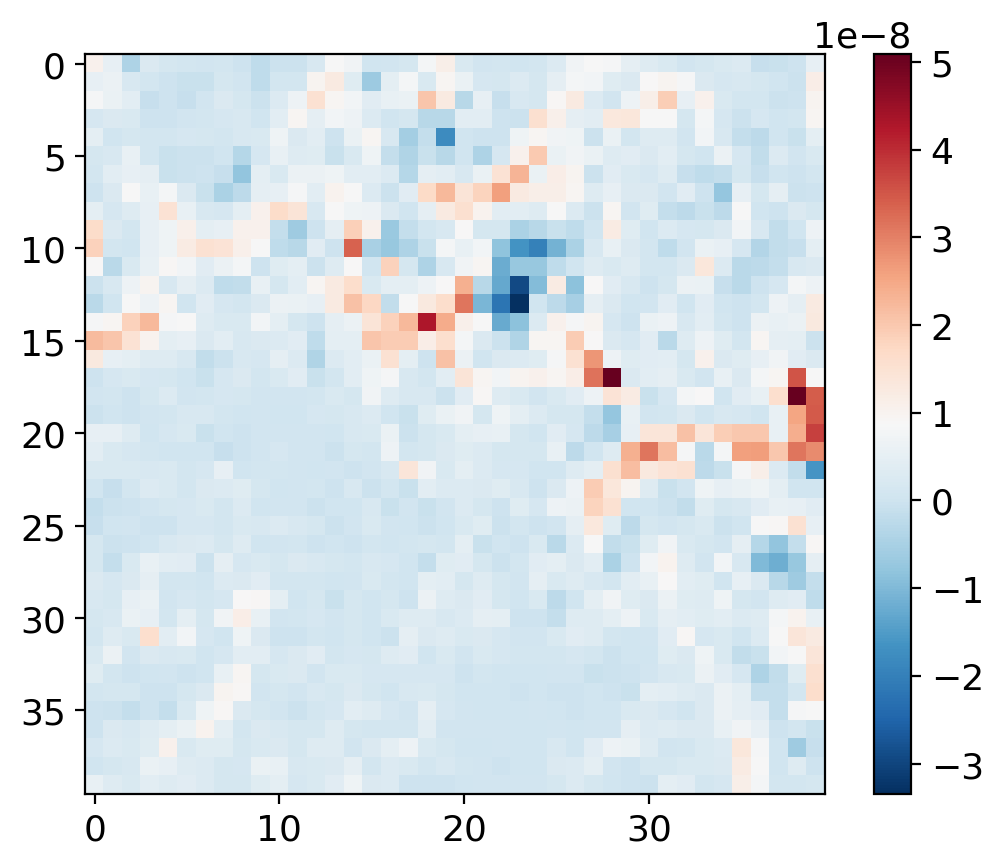

In [77]:
plt.imshow(np.flip(y_test_np[0],axis=0),cmap='RdBu_r')
plt.colorbar()

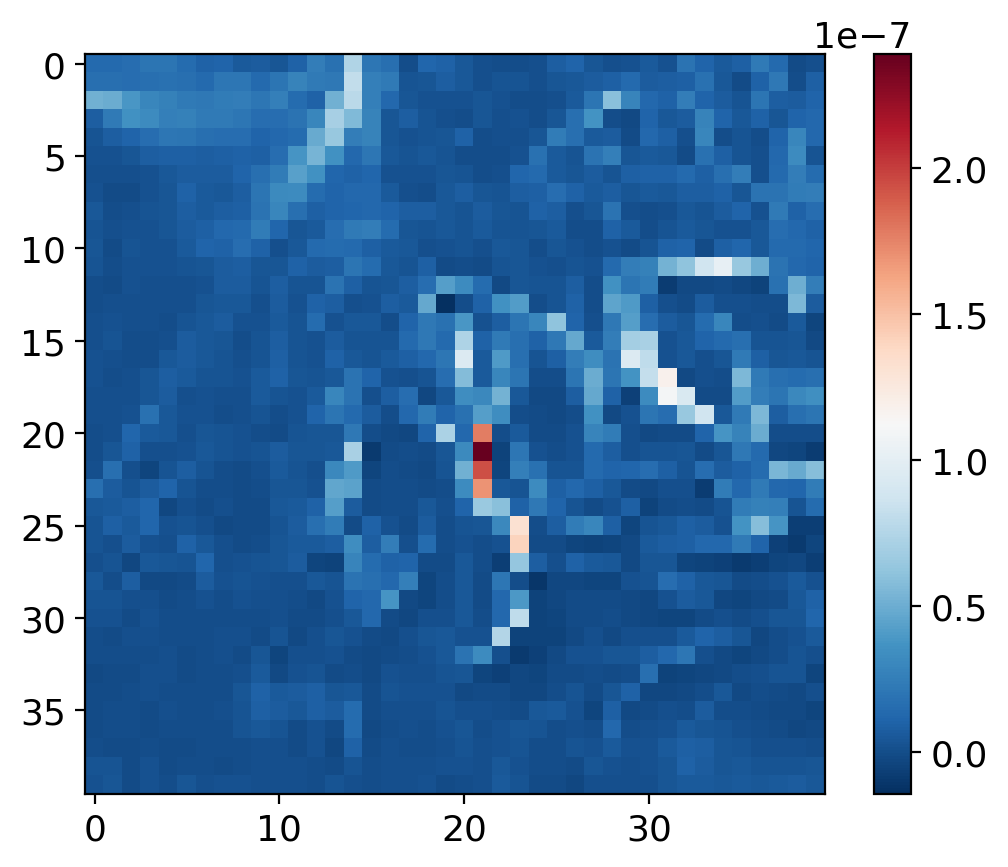

In [75]:
# looking at a still ordered, non-normalized WB_sg_xr
plt.imshow(np.flip(WB_sg_xr.data[1],axis=0),cmap='RdBu_r')

# Randomized order, 80% of WB_sg_xr. aka y_train
#plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

In [14]:
in_features=[]
for input_feature in input_features:
    in_features.append(np.load('data/%s.npy' % input_feature))
bro = np.stack(in_features,axis=1)

In [15]:
bro.shape

(10152, 9, 40, 40)

In [41]:
# Emulating what abigail has done with splitting training and testing

# takes all of the time tick indices, shuffles them randomly.
time_ind = bro.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 123
random.Random(rand_seed).shuffle(rand_ind)
# rand_ind is [0, 846 or whatever is the time tick length] but shuffled.

# take 80% for training, 20% for testing
train_split = 0.8
train_ind, test_ind = rand_ind[:round(train_split*time_ind)], rand_ind[round((train_split)*time_ind):]
print("Amount of indices in training data: ", train_ind.shape)
print("Amount of indices in testing data: ", test_ind.shape)

# sort back into order
sorted_train_ind = np.sort(train_ind)


# So, what we're seeing is she's just taking 80% of the dataset to use as training data.
# Take 80% totally randomly. 80% of the time ticks are set as training.
# 20% of the time ticks are set to be testing.
# Every one of the 9 input variables, and the 1 output variable share the same time series ticks.
# so it's gonna be 80% of the input and output = train, and 20% of the input and output = test.

Amount of indices in training data:  (8122,)
Amount of indices in testing data:  (2030,)
